In [381]:
import numpy as np
import random
from numpy.linalg import*
import matplotlib.pyplot as plt
from numpy import r_, exp, cos, sin, pi, zeros, ones, hanning, sqrt, log, floor, reshape, mean
from scipy import signal,stats 
from numpy.fft import fft
import math
import time
import scipy.optimize as opt
from sklearn.decomposition import FastICA, PCA

import scipy.io as sio
import scipy.io.wavfile
import sounddevice as sd
from IPython.display import Audio

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import copy
%matplotlib inline
import librosa
import librosa.display

import importlib
import Library_HS_210609 as lib_HS 
importlib.reload(lib_HS)

import ConvBSS_JadeICA_v2 as BSS_jica
importlib.reload(BSS_jica)

import ConvBSS_AoAPrior as BSS_prior
importlib.reload(BSS_prior)

import ConvBSS_MVDR as BSS_MVDR
importlib.reload(BSS_MVDR)

import DUET_module_HS as BSS_DUET
importlib.reload(BSS_DUET)

import scipy.stats as stats
import itertools 
import resampy
import nussl


def vec(X):
    return np.reshape(X,-1,order='F')
from sklearn.neighbors import KernelDensity

class Lap_pdf(stats.rv_continuous):
    def _pdf(self,x,b):
        return np.exp(-abs(x)/b)/(2*b)
class Tri_pdf(stats.rv_continuous):
    def _pdf(self,x):
        return -abs(x)+1
def center(X):
    mean = np.mean(X, axis=1, keepdims=True)
    centered =  X - mean 
    return centered, mean

def covariance(X):
    mean = np.mean(X, axis=1, keepdims=True)
    n = np.shape(X)[1] - 1
    m = X - mean

    return (m.dot(m.T))/n


def eval_SI_SDR(s_ref,s_est):
    s_tilda = np.vdot(s_ref,s_est)*s_ref/np.square(np.linalg.norm(s_ref,ord=2))
    e_tilda = s_est-s_tilda
    return 20*np.log10(np.linalg.norm(s_tilda,ord=2)/np.linalg.norm(e_tilda,ord=2))
def eval_SDR(s_ref,s_est):
    e = s_est-s_ref
    return 20*np.log10(np.linalg.norm(s_ref,ord=2)/np.linalg.norm(e,ord=2))
def eval_SNR(s_ref,s_est):
    s_tilda = np.vdot(s_ref,s_est)*s_ref/np.square(np.linalg.norm(s_ref,ord=2))
    e_tilda = s_est-s_tilda
    return 20*np.log10(np.linalg.norm(s_ref,ord=2)/np.linalg.norm(s_est-s_ref,ord=2))
def rej_outlier(data, m=2.5):
    return data[abs(data - np.mean(data,axis=0)) < m * np.std(data,axis=0)]

def AoA_clip_number(data):
    if data>180:
        data -= 360
    if data<-180:
        data += 360
    return data
def AoA_clip(data):
    for i in range(len(data)):
        if data[i]>180:
            data[i] -= 360
        if data[i]<-180:
            data[i] += 360
    return data

In [422]:
## LibriTTS dataset
N_test = 11
N_len = 1800000
TTS_raw = np.zeros((N_test,N_len))
for i in range(1,N_test+1):

    TTS_i_raw, fs_true = librosa.load('./VoiceRecords/ICASSP22_data/LibriTTS_'+str(i)+'.wav', sr=None)
    TTS_raw[i-1,:] = TTS_i_raw[:N_len]
TTS = np.zeros((N_test,N_len))
print(np.linalg.norm(TTS_raw,ord=2,axis=1)/np.min(np.linalg.norm(TTS_raw,ord=2,axis=1)))
for i in range(N_test):
    TTS[i,:] = TTS_raw[i,:]/(np.linalg.norm(TTS_raw,ord=2,axis=1)/np.min(np.linalg.norm(TTS_raw,ord=2,axis=1)))[i]
print(np.linalg.norm(TTS,ord=2,axis=1))
Data_perm = np.array([[0,1,2],[1,2,3],[2,3,4],[3,4,5],[4,5,6],[5,6,7],[6,7,8],[7,8,9],[8,9,10],[9,10,0],[10,0,2],
                     [0,2,4],[2,4,6],[4,6,8],[10,1,3],[1,3,5],[3,5,7],[5,7,9],[7,9,0],[0,3,6],[3,6,9]])
Data_numsrc = np.array([[10],[10,1],[10,1,2],[10,1,2,3],[10,1,2,3,4]])

[1.06183842 2.31906788 2.20935644 2.20264334 2.99873223 1.
 2.39911236 1.67068143 2.19496841 2.70237069 1.97145268]
[41.47509867 41.47509867 41.47509867 41.47509867 41.47509867 41.47509867
 41.47509867 41.47509867 41.47509867 41.47509867 41.47509867]


<ipython-input-422-ea4dec6deae4>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_numsrc = np.array([[10],[10,1],[10,1,2],[10,1,2,3],[10,1,2,3,4]])


In [493]:
## Signal generation first.
## Program Init.

#Donna, fs_true = librosa.load('./VoiceRecords/Donna.wav', sr=None)
#Nurse, fs_true = librosa.load('./VoiceRecords/WeekendNurse.wav', sr=None)
#BGM, fs_true = librosa.load('./VoiceRecords/WaitingMusic.wav', sr=None)
#JinZ, fs_true = librosa.load('./VoiceRecords/JinZhou.wav', sr=None)


# Signal Generation

# Linear Arrays referenced at the edge of element (index = 0).


Angle = np.array([170,70,-50,-125,10])#, -45, -5])#, 30, 45, 65])     # Impinging Angles from the right
Angle_bck = copy.deepcopy(Angle)
count = 0
theta_rot = 0
Angle = Angle - theta_rot
Angle = AoA_clip(Angle)
print(Angle)

M = 2 # Antenna array count
vp = 340    # Propagation velocity in [m/s]
d_over_lamb = 0.5   # distance between element / wavelength
fmax =  5e3
d = d_over_lamb*vp/fmax # fmax is assumed to be 10 KHz
K = len(Angle)      #  Number of impinging signals

Ns_true = 20*fs_true    # Sample number 
t_true = np.arange(Ns_true)/fs_true
SigVec = np.zeros((K,Ns_true))
factor_ups = 10
SNR = 25


[ 170   70  -50 -125   10]


In [433]:
## Vanila DUET
##Evaluation
count=0
Ns_test = 5*fs_true
perm = 10
numsrc = 2
autos=0
for autos in range(5):
    print('------perm------: ',perm)
    #SigVec_test = TTS[Data_perm[perm],Ns_test*count:Ns_test*count+Ns_test]
    SigVec_test = TTS[Data_numsrc[numsrc-1],Ns_test*count:Ns_test*count+Ns_test]
    X = lib_HS.MixGen(SigVec_test, AoA_clip(Angle_bck), M, fs_true, SNR, factor_ups, vp, d)
    N_fft = 1024*2    ### L_frame : Lengt of frame
    y_D_test, peakdelta = BSS_DUET.DUET(X, fs_true, N_fft, int(0.5*N_fft),0.05, 0.3, 0 , 0)
    AoA_D=np.arccos(-1*(vp/d)*peakdelta/fs_true)*180/np.pi
    print('AoA_truth = ', Angle_bck)
    print('AoA_est = ',AoA_D)

    for k in range(numsrc):
        val = []
        for j in range(len(peakdelta)):
            val.append(eval_SI_SDR(y_D_test[j,:],SigVec_test[k,:]))
            #print("SI_SDR: Src(%d),Est(%d): "%(k,j),eval_SI_SDR(y_D_test[j,:],SigVec_test[k,:]))
        print('SI-SDR: ',max(val))
    for k in range(numsrc):
        val = []
        for j in range(len(peakdelta)):    
            val.append(eval_SDR(y_D_test[j,:],SigVec_test[k,:]))
            #print("SDR: Src(%d),Est(%d): "%(k,j),eval_SDR(y_D_test[j,:],SigVec_test[k,:]))
        print('SDR: ',max(val))
    numsrc = numsrc+1
    #perm = perm+1

------perm------:  10
number of peaks:  2
AoA_truth =  [ 170   70  -50 -125   10]
AoA_est =  [ 70.52877937 159.95002428]
SI-SDR:  9.2259023758004
SI-SDR:  8.049564597138723
SDR:  1.5800658074869136
SDR:  1.5922546853872563
------perm------:  10
number of peaks:  3
AoA_truth =  [ 170   70  -50 -125   10]
AoA_est =  [ 54.84729703  70.52877937 159.95002428]
SI-SDR:  7.249437604820484
SI-SDR:  1.7574343595447233
SI-SDR:  6.034017426287543
SDR:  1.5475290858453672
SDR:  1.1760081341950421
SDR:  1.553826919588169
------perm------:  10
number of peaks:  4
AoA_truth =  [ 170   70  -50 -125   10]
AoA_est =  [ 54.84729703  70.52877937 125.15270297 151.49648988]
SI-SDR:  3.5627118933760498
SI-SDR:  0.7405876792559729
SI-SDR:  4.74501075379955
SI-SDR:  2.1726283617700313
SDR:  1.8441324037570375
SDR:  1.235437993226901
SDR:  1.8320377750904853
SDR:  1.3218825804049341
------perm------:  10
number of peaks:  4
AoA_truth =  [ 170   70  -50 -125   10]
AoA_est =  [ 28.50351012  54.84729703  66.8001568

IndexError: index 5 is out of bounds for axis 0 with size 5

In [190]:
print(d)
Audio(X[1,:],rate =fs_true)

0.034



------start------
Count: 0
True Angles-local: [ 170   70  -50 -125   10]


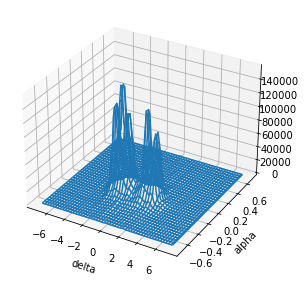

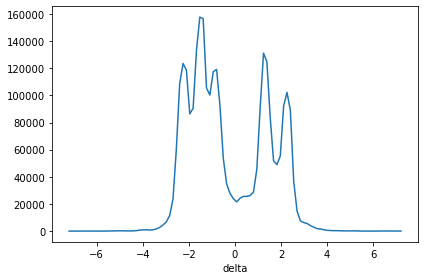

number of peaks:  5
AoA_local =  [ 20.04997572  50.47880364  70.52877937 121.00758301 159.95002428]

------start------
Count: 1
True Angles-local: [ 125   25  -95 -170  -35]


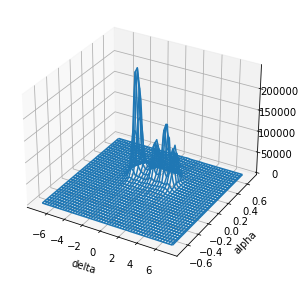

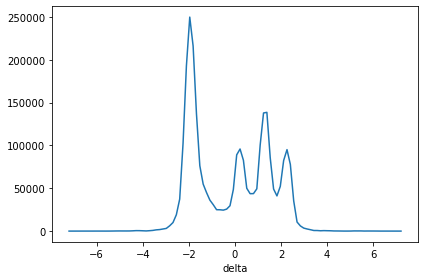

number of peaks:  4
AoA_local =  [ 35.09680123  95.21590857 125.15270297 159.95002428]

------start------
Count: 2
True Angles-local: [  80  -20 -140  145  -80]


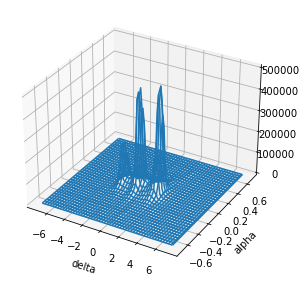

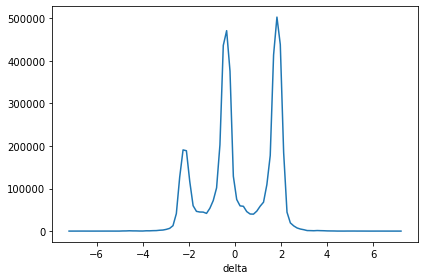

number of peaks:  3
AoA_local =  [ 20.04997572  81.28525798 139.25094562]


In [494]:
## Exploration Step

Angle = Angle_bck
count = 0
count_iter = 3 #15
#count_iter =  16+3
cov_y = np.zeros(count_iter)
#feat_avg = np.zeros((count_iter,2))
#feat_std = np.zeros((count_iter,2))
dtheta_step = 45
rot_ang = np.linspace(0,dtheta_step*(count_iter-1),count_iter)
#AoA_D_save = np.array([])
AoA_D_save = []

perm = 0
numsrc = 5
for iter in range(count_iter):
    print('\n------start------')
    print('Count:',count)
    print('True Angles-local:',Angle[:numsrc])
    #SigVec = TTS[Data_perm[perm],Ns_true*count:Ns_true*count+Ns_true]
    SigVec = TTS[Data_numsrc[numsrc-1],Ns_true*count:Ns_true*count+Ns_true]
    X = lib_HS.MixGen(SigVec, Angle[:numsrc], M, fs_true, SNR, factor_ups, vp, d)
    
    ## Apply DUET after rotation   
    N_fft = 1024*2    ### L_frame : Lengt of frame
    #N_hop = N_fft*0.25  ## Frame_shift
     
    y_D, peakdelta = BSS_DUET.DUET(X, fs_true, N_fft, int(0.5*N_fft),0.1, 0.3, 0 , 1)
    AoA_D=np.arccos(-1*(vp/d)*peakdelta/fs_true)*180/np.pi
    print('AoA_local = ',AoA_D)
    
    
    AoA_cand_p = rot_ang[iter] + AoA_D  #  AoA_global x rot_ang
    AoA_cand_n = rot_ang[iter] - AoA_D   #  AoA_global x rot_ang
    AoA_cand = AoA_clip(np.concatenate((AoA_cand_p, AoA_cand_n)))
    AoA_D_save.append(AoA_cand)
    #AoA_D_save = np.append(AoA_D_save,AoA_cand)
    
    Angle = AoA_clip(Angle - dtheta_step)
    count = count+1

estimated AoAs:  [ 167.   73.   13.  -50. -122.]
true AOAs:  [ 170   70  -50 -125   10]


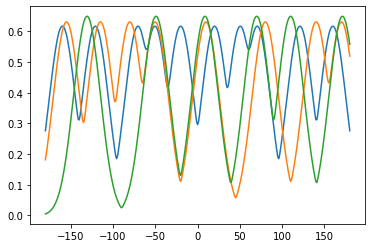

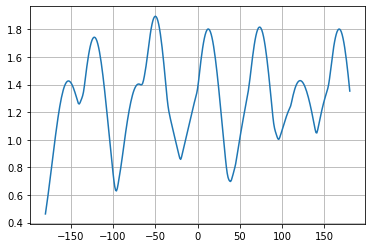

In [495]:
AoA_space = np.linspace(-180,180,361)
KDE_vec = np.zeros((len(AoA_space),len(AoA_D_save)))
for i in range(len(AoA_D_save)):
    a = AoA_D_save[i].reshape(-1, 1)
    #kde = KernelDensity(kernel='exponential', bandwidth=2.5).fit(a)
    kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(a)
    KDE_vec[:,i] = np.exp(kde.score_samples(AoA_space.reshape(-1,1))/10)
    plt.figure(0)
    plt.plot(AoA_space, KDE_vec[:,i])
f_score = np.sum(KDE_vec,axis=1)
#plt.ylim([-50,0])
plt.figure(1)
plt.plot(AoA_space, f_score)
#plt.ylim([-50,0])
plt.grid()
peaks, _ = signal.find_peaks(f_score, prominence = 0.1, height=1.6)
print('estimated AoAs: ',-np.sort(-AoA_space[peaks]))
print('true AOAs: ', Angle_bck[:numsrc])
if len(peaks)==numsrc:
    Angle_est = -np.sort(-AoA_space[peaks])
    Angle_Align = np.zeros(K)
    #for i in range(K):
    #    Angle_Align[i]=(np.sum(AoA_space[peaks])+np.sort(-AoA_space[peaks])[i])/2
    #print(Angle_Align)

In [484]:
-np.sort(-AoA_space[peaks])

array([ 166.,   68.,  -51., -124.])

In [497]:
print(Angle_est)
print(Find_AlignRotAng(Angle_est,0))


[ 167.   73.   13.  -50. -122.]
-24.5


[-165.5   94.5  -25.5 -100.5   34.5]


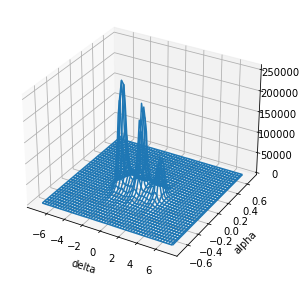

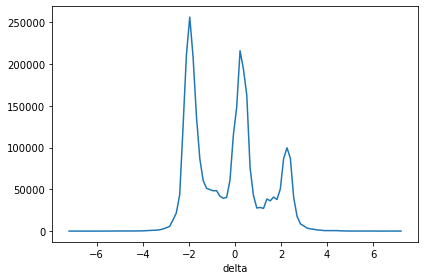

number of peaks:  3
AoA_local =  [ 35.09680123  95.21590857 159.95002428]
SI_SDR: Src(0),Est(0):  -37.43716943688504
SDR: Src(0),Est(0):  -0.1064315737661615
SI_SDR: Src(0),Est(1):  -16.123209617709193
SDR: Src(0),Est(1):  0.1029978124196664
SI_SDR: Src(0),Est(2):  4.6776109356348
SDR: Src(0),Est(2):  1.987947654646006
[  80.  -20. -140.  145.  -80.]


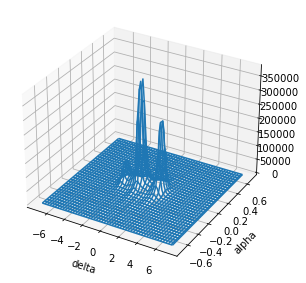

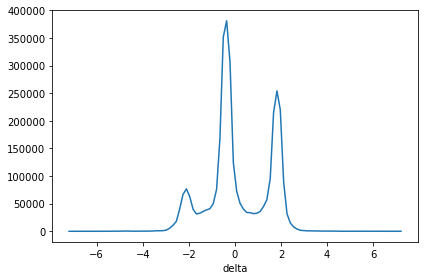

number of peaks:  3
AoA_local =  [ 28.50351012  81.28525798 139.25094562]
SI_SDR: Src(1),Est(0):  3.9766764918109567
SDR: Src(1),Est(0):  1.9513937681433469
SI_SDR: Src(1),Est(1):  -18.764816795201313
SDR: Src(1),Est(1):  0.05527849795365666
SI_SDR: Src(1),Est(2):  -44.23939050864771
SDR: Src(1),Est(2):  -0.10149088141376314
[ 158.5   58.5  -61.5 -136.5   -1.5]


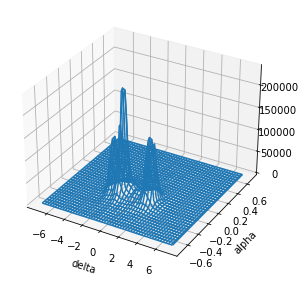

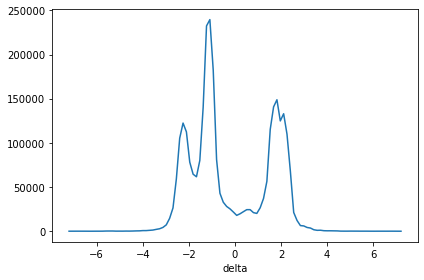

number of peaks:  3
AoA_local =  [ 20.04997572  62.96430821 139.25094562]
SI_SDR: Src(2),Est(0):  -24.45039027088533
SDR: Src(2),Est(0):  -0.10398653675182407
SI_SDR: Src(2),Est(1):  -1.7854280107422402
SDR: Src(2),Est(1):  0.8389057759049896
SI_SDR: Src(2),Est(2):  -29.873482285323014
SDR: Src(2),Est(2):  -0.06338156131945623
[-135.5  124.5    4.5  -70.5   64.5]


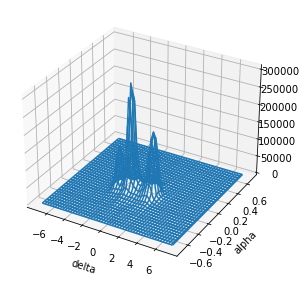

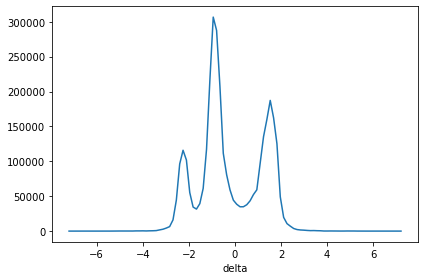

number of peaks:  3
AoA_local =  [ 20.04997572  66.80015682 129.52119636]
SI_SDR: Src(3),Est(0):  -28.35772675640222
SDR: Src(3),Est(0):  -0.1866221217788241
SI_SDR: Src(3),Est(1):  -3.178076353177393
SDR: Src(3),Est(1):  0.6891968533863674
SI_SDR: Src(3),Est(2):  -26.49290412464183
SDR: Src(3),Est(2):  -0.05115496119941634
[ 111.5   11.5 -108.5  176.5  -48.5]


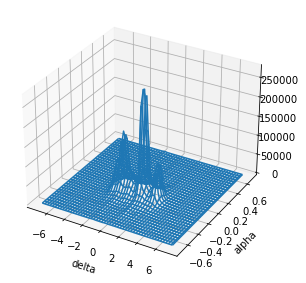

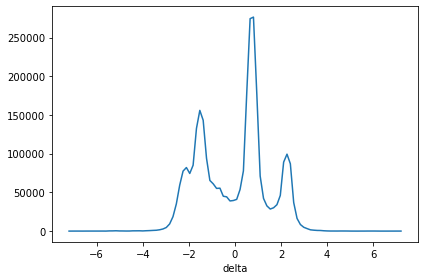

number of peaks:  3
AoA_local =  [ 50.47880364 109.47122063 159.95002428]
SI_SDR: Src(4),Est(0):  -0.26559223835775314
SDR: Src(4),Est(0):  1.061400118107579
SI_SDR: Src(4),Est(1):  -21.932037156640646
SDR: Src(4),Est(1):  -0.013622472714200511
SI_SDR: Src(4),Est(2):  -48.09261737569615
SDR: Src(4),Est(2):  -0.3429931084055422


In [500]:
##Evaluation
count=0
Ns_test = 20*fs_true
perm = 0
numsrc=5
#Angle_est = Angle_bck[:numsrc]
#SigVec_test = TTS[Data_perm[perm],Ns_test*count:Ns_test*count+Ns_test]
SigVec_test = TTS[Data_numsrc[numsrc-1],Ns_test*count:Ns_test*count+Ns_test]
for k in range(numsrc):
    #X = lib_HS.MixGen(SigVec_test, AoA_clip(Angle_bck), M, fs_true, SNR, factor_ups, vp, d)
    X = lib_HS.MixGen(SigVec_test, AoA_clip(Angle_bck[:numsrc]-Find_AlignRotAng(Angle_est,k)), M, fs_true, SNR, factor_ups, vp, d)
     ## Apply DUET after rotation   
    N_fft = 1024*2    ### L_frame : Lengt of frame
    #N_hop = N_fft*0.25  ## Frame_shift
    print(AoA_clip(Angle_bck[:numsrc]-Find_AlignRotAng(Angle_est,k)))
    y_D_test, peakdelta = BSS_DUET.DUET(X, fs_true, N_fft, int(0.5*N_fft),0.05, 0.3, 0 , 1)
    AoA_D=np.arccos(-1*(vp/d)*peakdelta/fs_true)*180/np.pi
    print('AoA_local = ',AoA_D)
    for j in range(len(peakdelta)):
        print("SI_SDR: Src(%d),Est(%d): "%(k,j),eval_SI_SDR(y_D_test[j,:],SigVec_test[k,:]))
        print("SDR: Src(%d),Est(%d): "%(k,j),eval_SDR(y_D_test[j,:],SigVec_test[k,:]))


------start------
Count: 3
True Angles-local: [178.5  78.5 -21.5 -91.5]


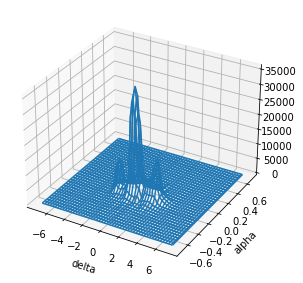

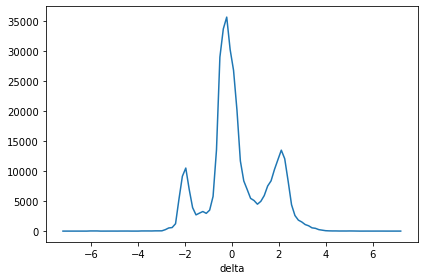

number of peaks:  3
AoA_local =  [ 27.05906604  84.32136653 163.03905266]
[178.5  78.5 -21.5 -91.5]
Src(0),Est(0):  -33.69303754758987
Src(0),Est(1):  -18.128423682632945
Src(0),Est(2):  6.385309916046335


In [265]:
## Exploit
k = 0  ## desired source

#AoA_D_save = np.array([])


print('\n------start------')
print('Count:',count)
print('True Angles-local:',AoA_clip(Angle_bck-Find_AlignRotAng(Angle_est,k)))
SigVec[0,:] = 0.47*TTSM[Ns_true*count:Ns_true*count+Ns_true]
#SigVec[4,:] = 0.63*TTSF[Ns_true*count:Ns_true*count+Ns_true]
SigVec[3,:] = 1.09*Donna[Ns_true*count:Ns_true*count+Ns_true]
SigVec[1,:] = 0.91*Nurse[Ns_true*count:Ns_true*count+Ns_true]
#SigVec[4,:] = 0.97*BGM[Ns_true*count:Ns_true*count+Ns_true]
SigVec[2,:] = 1.01*JinZ[Ns_true*count:Ns_true*count+Ns_true]
X = lib_HS.MixGen(SigVec, AoA_clip(Angle_bck-Find_AlignRotAng(Angle_est,k)), M, fs_true, SNR, factor_ups, vp, d)

## Apply DUET after rotation   
N_fft = 1024    ### L_frame : Lengt of frame
#N_hop = N_fft*0.25  ## Frame_shift

y_D, peakdelta = BSS_DUET.DUET(X, fs_true, N_fft, int(0.5*N_fft),0.1, 0.3, 0 , 1)
AoA_D=np.arccos(-1*(vp/d)*peakdelta/fs_true)*180/np.pi
print('AoA_local = ',AoA_D)
print(AoA_clip(Angle_bck-Find_AlignRotAng(Angle_est,k)))

AoA_cand_p = Find_AlignRotAng(Angle_est,k) + AoA_D  #  AoA_global x rot_ang
AoA_cand_n = Find_AlignRotAng(Angle_est,k) - AoA_D   #  AoA_global x rot_ang
AoA_cand = AoA_clip(np.concatenate((AoA_cand_p, AoA_cand_n)))
AoA_D_save.append(AoA_cand)
#AoA_D_save = np.append(AoA_D_save,AoA_cand)
for j in range(len(peakdelta)):
    print("Src(%d),Est(%d): "%(k,j),eval_SI_SDR(y_D[j,:],SigVec[k,:]))    


In [156]:
def Find_AlignRotAng(Angle_est, index_want):
    k = index_want
    Theta_align = np.average(np.array(list(itertools.combinations(Angle_est, 2))),axis=1)
    Q = np.zeros((len(Theta_align)))
    for i in range(len(Theta_align)):
        Q_list = np.abs(np.abs(AoA_clip(Angle_est - Theta_align[i]))-np.abs(AoA_clip_number(Angle_est[k] - Theta_align[i])))
        #print(np.delete(Q_list,k))
        Q[i] = np.min(np.delete(Q_list,k))
    
    #print('pick index i :',np.argmax(Q))
    return Theta_align[np.argmax(Q)]
Find_AlignRotAng(Angle_est,0)

-14.0

In [138]:
print(AoA_D_save)

[array([  29.06766028,   69.73758454,   98.53554847,  166.65434634,
        -29.06766028,  -69.73758454,  -98.53554847, -166.65434634]), array([  71.42870659,   99.05506696,  120.26241546,  165.098022  ,
        -51.42870659,  -79.05506696, -100.26241546, -145.098022  ]), array([  69.97166594,  136.44055166,  167.25261456,  -29.97166594,
        -96.44055166, -127.25261456]), array([  -0.65434634,   71.27017881,  146.05363366,  -27.34565366,
        -99.27017881, -174.05363366])]


---------index number i: 0 ----------
[  50.  -50. -150.  140.]


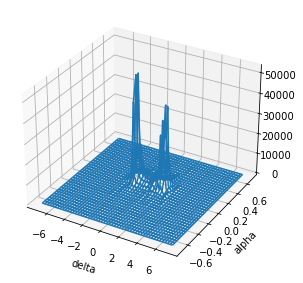

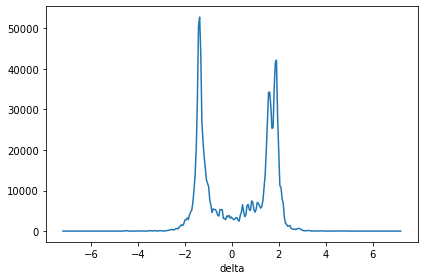

number of peaks:  3
Src(0),Est(0):  -1.136565761204127
Src(0),Est(1):  -21.09713896868447
Src(0),Est(2):  -36.20806911768726
Src(1),Est(0):  -0.9559159649335837
Src(1),Est(1):  -20.296607341304153
Src(1),Est(2):  -29.48041136662937
Src(2),Est(0):  -29.473153712869294
Src(2),Est(1):  -12.073674399886638
Src(2),Est(2):  2.5373682705030562
Src(3),Est(0):  -24.90114305958951
Src(3),Est(1):  1.3167463488803175
Src(3),Est(2):  -13.626786622659441
---------index number i: 1 ----------
[ 100.    0. -100. -170.]


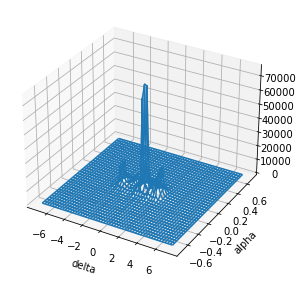

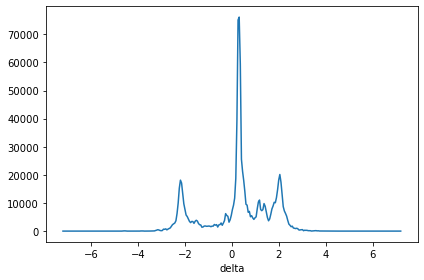

number of peaks:  3
Src(0),Est(0):  -24.688507623253546
Src(0),Est(1):  -2.533321062432024
Src(0),Est(2):  -23.220070585587827
Src(1),Est(0):  5.852983909014414
Src(1),Est(1):  -18.405718470363603
Src(1),Est(2):  -38.952294909387604
Src(2),Est(0):  -29.64307717450438
Src(2),Est(1):  -1.7401169962587673
Src(2),Est(2):  -22.742541101203795
Src(3),Est(0):  -61.057983309712334
Src(3),Est(1):  -16.516532818013573
Src(3),Est(2):  5.215926571402073
---------index number i: 2 ----------
[ 135.   35.  -65. -135.]


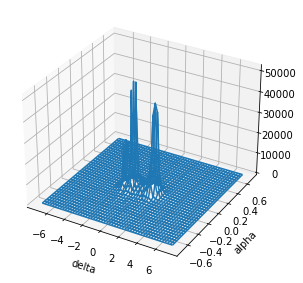

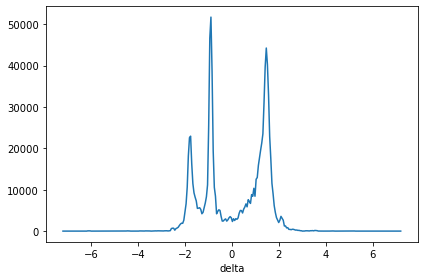

number of peaks:  3
Src(0),Est(0):  -53.788952751592085
Src(0),Est(1):  -22.68530447244649
Src(0),Est(2):  -1.6885453171221807
Src(1),Est(0):  3.849859271853207
Src(1),Est(1):  -12.455762424424726
Src(1),Est(2):  -30.56149532704209
Src(2),Est(0):  -23.320388506969152
Src(2),Est(1):  1.7275447423556634
Src(2),Est(2):  -22.22146590422235
Src(3),Est(0):  -37.370543856923476
Src(3),Est(1):  -19.658624533913574
Src(3),Est(2):  -0.5291496238344977
---------index number i: 3 ----------
[ 150.   50.  -50. -120.]


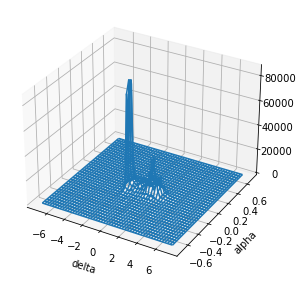

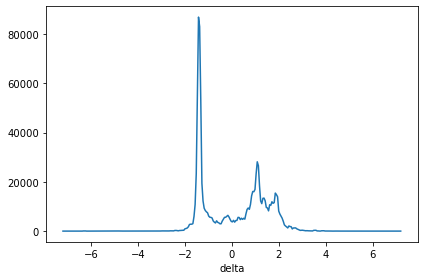

number of peaks:  2
Src(0),Est(0):  -31.290064862994356
Src(0),Est(1):  -1.571151823347909
Src(1),Est(0):  -1.279336400237319
Src(1),Est(1):  -23.808600551795426
Src(2),Est(0):  -1.3084612364970825
Src(2),Est(1):  -21.663881203743074
Src(3),Est(0):  -25.133427357357423
Src(3),Est(1):  -0.6238297507058117
---------index number i: 4 ----------
[-175.   85.  -15.  -85.]


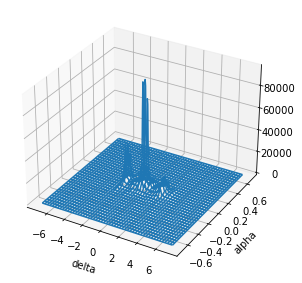

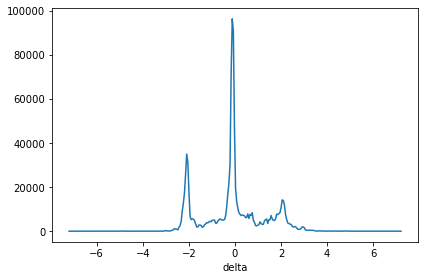

number of peaks:  3
Src(0),Est(0):  -38.86361086874305
Src(0),Est(1):  -18.62503980980652
Src(0),Est(2):  6.426025777128545
Src(1),Est(0):  -31.54158209094339
Src(1),Est(1):  -1.9590177412726095
Src(1),Est(2):  -28.249330270160456
Src(2),Est(0):  6.07322509854955
Src(2),Est(1):  -19.302232132404033
Src(2),Est(2):  -51.513876530507304
Src(3),Est(0):  -25.35643009847243
Src(3),Est(1):  -1.144256448129743
Src(3),Est(2):  -26.176999387581947
---------index number i: 5 ----------
[-125.  135.   35.  -35.]


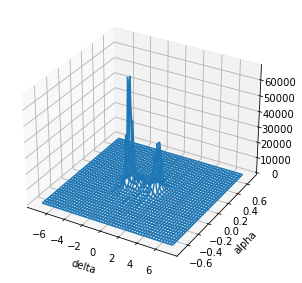

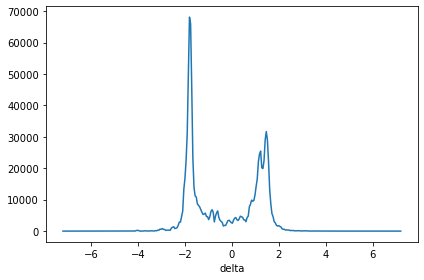

number of peaks:  2
Src(0),Est(0):  -24.80431868821798
Src(0),Est(1):  -1.2194853052120829
Src(1),Est(0):  -26.722186672483428
Src(1),Est(1):  -0.8629640774194142
Src(2),Est(0):  -1.299228272737575
Src(2),Est(1):  -28.59580353139328
Src(3),Est(0):  -0.6835349665493984
Src(3),Est(1):  -25.13423840736285


In [33]:
count=0
Ns_test = 200000 
SigVec_test = np.zeros((K,Ns_test))
for i in range(math.comb(K,2)):
    print('---------index number i: %d ----------'%i)
    SigVec_test[0,:] = 0.47*TTSM[Ns_test*count:Ns_test*count+Ns_test]
    #SigVec_test[1,:] = 0.63*TTSF[Ns_true*count:Ns_true*count+Ns_true]
    SigVec_test[3,:] = 1.09*Donna[Ns_test*count:Ns_test*count+Ns_test]
    SigVec_test[1,:] = 0.91*Nurse[Ns_test*count:Ns_test*count+Ns_test]
    #SigVec_test[0,:] = 0.97*BGM[Ns_true*count:Ns_true*count+Ns_test]
    SigVec_test[2,:] = 1.01*JinZ[Ns_test*count:Ns_test*count+Ns_test]
    X = lib_HS.MixGen(SigVec_test, AoA_clip(Angle_bck-Theta_align[i]), M, fs_true, SNR, factor_ups, vp, d)

    ## Apply DUET after rotation   
    N_fft = 1024    ### L_frame : Lengt of frame
    #N_hop = N_fft*0.25  ## Frame_shift
    print(AoA_clip(Angle_bck-Theta_align[i]))
    y_D_test, peakdelta = BSS_DUET.DUET(X, fs_true, N_fft, int(0.5*N_fft),0.1, 0.3, 0 , 1)
    for j in range(K):
        for k in range(len(peakdelta)):
            print("Src(%d),Est(%d): "%(j,k),eval_SI_SDR(y_D_test[k,:],SigVec_test[j,:]))

[ 170   70  -30 -100]


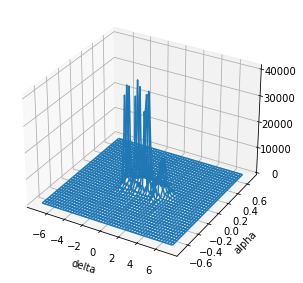

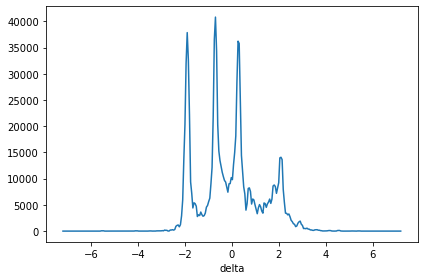

number of peaks:  4
Src(0),Est(0):  -39.64593068982663
Src(0),Est(1):  -39.104294843134085
Src(0),Est(2):  -14.069470713086186
Src(0),Est(3):  6.062714262028587
Src(1),Est(0):  -28.049610116572875
Src(1),Est(1):  1.6787357679670971
Src(1),Est(2):  -16.9087223387615
Src(1),Est(3):  -36.13369368049455
Src(2),Est(0):  5.391734317584225
Src(2),Est(1):  -15.682218443887097
Src(2),Est(2):  -26.23124640657992
Src(2),Est(3):  -53.537343809452565
Src(3),Est(0):  -41.854854634947685
Src(3),Est(1):  -14.370924080662933
Src(3),Est(2):  1.8056583232120724
Src(3),Est(3):  -25.72564464946261


In [14]:
X = lib_HS.MixGen(SigVec_test, AoA_clip(Angle_bck), M, fs_true, SNR, factor_ups, vp, d)

## Apply DUET after rotation   
N_fft = 1024    ### L_frame : Lengt of frame
#N_hop = N_fft*0.25  ## Frame_shift
print(AoA_clip(Angle_bck))
y_D_test, peakdelta = BSS_DUET.DUET(X, fs_true, N_fft, int(0.5*N_fft),0.2, 0.3, 0 , 1)
for j in range(K):
    for k in range(len(peakdelta)):
        print("Src(%d),Est(%d): "%(j,k),eval_SI_SDR(y_D_test[k,:],SigVec_test[j,:]))

In [43]:
print(np.round(np.corrcoef(SigVec,y_D),2))


[[ 1.    0.02  0.   -0.02  0.15  0.91]
 [ 0.02  1.   -0.01  0.06  0.84  0.05]
 [ 0.   -0.01  1.    0.88  0.15  0.04]
 [-0.02  0.06  0.88  1.    0.05  0.  ]
 [ 0.15  0.84  0.15  0.05  1.    0.07]
 [ 0.91  0.05  0.04  0.    0.07  1.  ]]


In [202]:
## Evaluation
print("----SI-SDR -----")
for j in range(K):
    for i in range(len(AoA_D)):
        print("Src(%d),Est(%d): "%(j,i),eval_SI_SDR(y_D[i,:],SigVec[j,:]))
        
print("----SDR -----")
for j in range(K):
    for i in range(len(AoA_D)):
        print("Src(%d),Est(%d): "%(j,i),eval_SDR(y_D[i,:],SigVec[j,:]))    


----SI-SDR -----
Src(0),Est(0):  4.26034605235132
Src(0),Est(1):  -12.803228435660767
Src(0),Est(2):  -27.28118184698296
Src(0),Est(3):  -38.223422503871745
Src(1),Est(0):  -38.386789648118636
Src(1),Est(1):  -18.926362854019125
Src(1),Est(2):  0.3550451402547294
Src(1),Est(3):  -25.768590147934578
Src(2),Est(0):  -39.757162305485004
Src(2),Est(1):  -23.85014257184104
Src(2),Est(2):  -12.722017175456594
Src(2),Est(3):  4.455001747903802
Src(3),Est(0):  -20.941053070015286
Src(3),Est(1):  1.2644305012043522
Src(3),Est(2):  -14.605018472877429
Src(3),Est(3):  -36.970168259316
----SDR -----
Src(0),Est(0):  3.967553381907854
Src(0),Est(1):  0.08885125417327966
Src(0),Est(2):  -0.5395839342762923
Src(0),Est(3):  -0.7979356647555619
Src(1),Est(0):  -0.8136818785708362
Src(1),Est(1):  -0.232560649386093
Src(1),Est(2):  2.276246513558809
Src(1),Est(3):  -0.5205573407269144
Src(2),Est(0):  -1.2415793892606506
Src(2),Est(1):  -0.5922038715063881
Src(2),Est(2):  -0.035422666047265336
Src(2),Est(3

In [ ]:
Audio(est[3,:],rate =fs_true)

In [ ]:
Audio(est[1,:],rate =fs_true)

In [ ]:
Audio(est[2,:],rate =fs_true)

In [ ]:
# SI-SDR i (improvement)
for i in range(numsources):
    print("SI-SDR_mix: ",eval_SI_SDR(x[0,:],SigVec[i,:]))
    print("SDR_mix: ",eval_SDR(x[0,:],SigVec[i,:]))

In [ ]:
fmax = 1.2e3
d = d_over_lamb*vp/fmax # fmax is assumed to be 10 KHz
print(d)

In [ ]:
theta_sweep = np.arange(-180,180,1)
vp = 330
d_over_lamb = 0.5   # distance between element / wavelength
fmax = 1.2e3
freq = 2e3
d = d_over_lamb*vp/fmax # fmax is assumed to be 10 KHz

a_vec = lib_HS.ArrayVec_deg_WB_COS(M,theta_sweep,freq,vp,d)[1,:]
a_0 = lib_HS.ArrayVec_deg_WB_COS(M,0,freq,vp,d)[1]
a_45 = lib_HS.ArrayVec_deg_WB_COS(M,45,freq,vp,d)[1]
a_90 = lib_HS.ArrayVec_deg_WB_COS(M,90,freq,vp,d)[1]
a_135 = lib_HS.ArrayVec_deg_WB_COS(M,135,freq,vp,d)[1]
a_180 = lib_HS.ArrayVec_deg_WB_COS(M,180,freq,vp,d)[1]
a_n180 = lib_HS.ArrayVec_deg_WB_COS(M,-180,freq,vp,d)[1]


###### Plot MVDR weight on graph################

a_f_1 = np.reshape(lib_HS.ArrayVec_deg_WB_COS(M,180,freq,vp,d),(2,1))
a_f_2 = np.reshape(lib_HS.ArrayVec_deg_WB_COS(M,90,freq,vp,d),(2,1))
a_f_3 = np.reshape(lib_HS.ArrayVec_deg_WB_COS(M,135,freq,vp,d),(2,1))
X_f = a_f_1*np.random.uniform(-1,1,size=1000)+a_f_2*np.random.uniform(-1,1,size=1000)#+a_f_3*np.random.uniform(-1,1,size=1000)
print(X_f.shape)
print(np.cov(X_f).shape)

W_mvdr = np.linalg.inv(np.cov(X_f))@a_f_1/np.diag((a_f_1.conj().T@np.linalg.inv(np.cov(X_f))@a_f_1))


print(np.vdot(W_mvdr,a_f_1))
print(np.vdot(W_mvdr,a_f_2))
print(np.vdot(W_mvdr,a_f_3))
print(W_mvdr/W_mvdr[0])
W_mvdr_norm = (W_mvdr/W_mvdr[0])[1]
print(W_mvdr_norm)
#    P_out[i,:] = np.diag(W_mvdr@np.cov(X_ft[:,i,:])@W_mvdr_H)
###########################################




fig = plt.figure(figsize = (12,5))
plt.subplot(121)
plt.plot(np.real(a_vec),np.imag(a_vec),':',color='black')
plt.plot(np.real(a_n180),np.imag(a_n180),'x',color='red',label='AoA = -180')
plt.plot(np.real(a_0),np.imag(a_0),'o', color='blue',label = 'AoA = 0')
plt.plot(np.real(a_45),np.imag(a_45),'o', color='orange',label = 'AoA = 45')
plt.plot(np.real(a_90),np.imag(a_90),'o', color='m',label = 'AoA = 90')
plt.plot(np.real(a_135),np.imag(a_135),'o', color='black',label = 'AoA = 135')
plt.plot(np.real(a_180),np.imag(a_180),'.', color='green',label = 'AoA = 180')
plt.plot(np.real(W_mvdr_norm),np.imag(W_mvdr_norm),'*', color='green',label = 'W_mvdr')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


a_80 = lib_HS.ArrayVec_deg_WB_COS(M,85,freq,vp,d)[1]
a_85 = lib_HS.ArrayVec_deg_WB_COS(M,80,freq,vp,d)[1]
a_170 = lib_HS.ArrayVec_deg_WB_COS(M,170,freq,vp,d)[1]
a_175 = lib_HS.ArrayVec_deg_WB_COS(M,175,freq,vp,d)[1]



plt.subplot(122)
plt.plot(np.real(a_vec),np.imag(a_vec),':',color='black')
plt.plot(np.real(a_80),np.imag(a_80),'o', color='brown',label = 'AoA = 80')
plt.plot(np.real(a_85),np.imag(a_85),'o', color='orange',label = 'AoA = 85')
plt.plot(np.real(a_90),np.imag(a_90),'o', color='blue',label = 'AoA = 90')
plt.plot(np.real(a_170),np.imag(a_170),'o', color='m',label = 'AoA = 170')
plt.plot(np.real(a_175),np.imag(a_175),'x', color='red',label = 'AoA = 175')
plt.plot(np.real(a_180),np.imag(a_180),'.', color='green',label = 'AoA = 180')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.plot(theta_sweep,np.angle(a_vec))

In [ ]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data

# save to csv file
#savetxt('./RUSSdata/210926/AoA_avg.csv', np.sort(feat_avg,axis=1), delimiter=',')
#savetxt('./RUSSdata/210926/feat_std_10deg_0p75sec_dataset1.csv', feat_std_min, delimiter=',')
savetxt('./RUSSdata/210926/feat_std_avg_10deg_0p3sec_dataset2.csv', feat_std_min, delimiter=',')
savetxt('./RUSSdata/210926/KDE_10deg_0p3sec_dataset2.csv', f_score, delimiter=',')
#savetxt('./RUSSdata/210926/cov_y.csv', cov_y, delimiter=',')

In [ ]:
#### Evaluation of source estimates
Ns_test = fs_true*5
SigVec_test = np.zeros((K,Ns_test))
count = 5
index_align = 0
#SigVec_test[0,:] = 0.47*TTSM[Ns_test*count:Ns_test*count+Ns_test]
#SigVec_test[1,:] = 0.63*TTSF[Ns_test*count:Ns_test*count+Ns_test]
#SigVec_test[0,:] =1.09* Donna[Ns_test*count:Ns_test*count+Ns_test]
SigVec_test[1,:] = 0.91*Nurse[Ns_test*count:Ns_test*count+Ns_test]
SigVec_test[0,:] = 0.97*BGM[Ns_test*count:Ns_test*count+Ns_test]
SigVec_test[2,:] = 1.01*JinZ[Ns_test*count:Ns_test*count+Ns_test]

for index_align in range(3):
    Angle_test = Angle_bck - Angle_Align[index_align]
    print("Angle_est  :",Angle_est)
    print("Angle_align:",Angle_Align)
    print("Angle_test :",Angle_test)

    X_test = lib_HS.MixGen(SigVec_test, Angle_test, M, fs_true, SNR, factor_ups, vp, d)

    ## Apply ICA after rotation   --Tentative 
    N_fft = 512*2      ### L_frame : Lengt of frame
    N_hop = N_fft*0.25  ## Frame_shift
    #f_LPF = 0.1*fs_true
    f_LPF = None


    f, t, _ = signal.stft(X_test[0,:], fs_true, nperseg=N_fft, noverlap = N_fft-N_hop)
    y_jica, Y_ft_jica, A_f_jica = BSS_jica.ConvBSS_JadeICA(X_test, fs_true,N_fft= N_fft, N_hop=N_hop, M=M, K=2, f_LPF = f_LPF)

    print("SI-SDR: ",eval_SI_SDR(y_jica[0,:],SigVec_test[index_align,:]))
    print("SI_SDR: ",eval_SI_SDR(y_jica[1,:],SigVec_test[index_align,:]))
    print("SDR: ",eval_SDR(y_jica[0,:],SigVec_test[index_align,:]))
    print("SDR: ",eval_SDR(y_jica[1,:],SigVec_test[index_align,:]))

In [ ]:
Audio(y_jica[0,:], rate=fs_true)
#Audio(SigVec_test[index_align,:], rate=fs_true)

In [ ]:
# SI-SDR i (improvement)
Ns_test = fs_true*5
SigVec_test = np.zeros((K,Ns_test))
count = 5
index_align = 0
SigVec_test[1,:] = 0.91*Nurse[Ns_test*count:Ns_test*count+Ns_test]
SigVec_test[0,:] = 0.97*BGM[Ns_test*count:Ns_test*count+Ns_test]
SigVec_test[2,:] = 1.01*JinZ[Ns_test*count:Ns_test*count+Ns_test]
X_test = lib_HS.MixGen(SigVec_test, Angle_test, M, fs_true, SNR, factor_ups, vp, d)
for i in range(3):
    print("SI-SDR_mix: ",eval_SI_SDR(X_test[0,:],SigVec_test[i,:]))
    print("SDR_mix: ",eval_SDR(X_test[0,:],SigVec_test[i,:]))

In [ ]:
print(eval_SDR(y_jica[0,:],SigVec_test[index_align,:]))
print(eval_SDR(y_jica[1,:],SigVec_test[index_align,:]))

In [ ]:
#### Evaluation 

import nussl
import json
#import ffmpeg
#import musdb
#import stempeg
#nussl.AudioSignal(list(SigVec))
ref_index = 2
est_index = 0
SigVec_NS = nussl.AudioSignal(audio_data_array=SigVec_test[ref_index,:], sample_rate=fs_true)
y_jica_NS = nussl.AudioSignal(audio_data_array=y_jica[est_index,:], sample_rate=fs_true)
eval_old = nussl.evaluation.BSSEvalV4(
    SigVec_NS,y_jica_NS)
eval_new = nussl.evaluation.BSSEvalScale(
    SigVec_NS,y_jica_NS)
scores_old = eval_old.evaluate()
scores_new = eval_new.evaluate()
print(json.dumps(scores_old, indent=2))
print(json.dumps(scores_new, indent=2))
#print(scores)
#list(SigVec.T)
#nussl.evaluation.BSSEvalScale(SigVec.T,SigVec.T)

In [ ]:

#print(vec(AoA_cand_proc))

#.kde import KernelDensity

a = vec(AoA_cand_proc).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(a)
s = np.linspace(-180,180,361)
e = kde.score_samples(s.reshape(-1,1))
plt.plot(s, np.exp(e/10))
#plt.ylim([-30,0])
plt.grid()


from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

In [ ]:
print(s)

In [ ]:
### Feature adjusted by slope of cosine graph   210922

rot_ang = np.linspace(0,dtheta_step*(count_iter-1),count_iter)
feat_std_AoA = feat_std/abs(np.sin(feat_avg))
feat_std_min_AoA = np.min(feat_std_AoA,axis=1)

plt.plot(rot_ang,feat_std_min_AoA)
plt.xlabel("rot_ang[deg]")
plt.ylabel("min(std)")
plt.grid(ls='--')

sort_show = 10

print((np.argsort(feat_std_min_AoA)[:sort_show]))
print(5*(np.argsort(feat_std_min_AoA)[:sort_show]))
print(feat_std_min_AoA[np.argsort(feat_std_min_AoA)[:sort_show]])

sort_max = 5
min_index = np.argsort(feat_std_min_AoA)[:sort_max]
print(rot_ang[min_index])
print(np.arccos(np.clip(feat_avg[min_index],-1,1))*180/np.pi)

AoA_cand_p = np.tile(rot_ang[min_index],(2,1)) + (np.arccos(np.clip(feat_avg[min_index],-1,1))*180/np.pi).T  #  AoA_global x rot_ang
AoA_cand_n = np.tile(rot_ang[min_index],(2,1)) - (np.arccos(np.clip(feat_avg[min_index],-1,1))*180/np.pi).T   #  AoA_global x rot_ang

#print(AoA_cand_p)
#print(AoA_cand_n)
AoA_cand = np.vstack((AoA_cand_p, AoA_cand_n))


#### Estimate three AoAs using histogram
#print(AoA_cand)
AoA_cand_proc = np.zeros((4,sort_max))
plt.figure(0)
for i in range(sort_max):
    AoA_cand_proc[:,i] = np.sort(AoA_clip(AoA_cand[:,i]))
    plt.hist(AoA_cand_proc[:,i],bins=180,range=(-180,180))
#print(AoA_cand_proc)
#plt.plot(AoA_cand_proc[:,0])
#plt.plot(AoA_cand_proc[:,1])


plt.figure(2)
n_hist, bins_hist, _= plt.hist(np.reshape(AoA_cand_proc,-1),bins=72,range=(-180,180))

print(np.argsort(-n_hist)[:4])
print(n_hist[np.argsort(-n_hist)[:4]])
bins_hist[np.argsort(-n_hist)[:4]]

In [ ]:
plt.plot(rot_ang,feat_std)

In [ ]:
#### Evaluation of source estimates
for count in np.argsort(feat_std_min)[:5]
    SigVec[0,:] = Donna[Ns_true*count:Ns_true*count+Ns_true]
    SigVec[1,:] = Nurse[Ns_true*count:Ns_true*count+Ns_true]
    #SigVec[1,:] = BGM[Ns_true*count:Ns_true*count+Ns_true]
    SigVec[2,:] = JinZ[Ns_true*count:Ns_true*count+Ns_true]
    X = lib_HS.MixGen(SigVec, Angle, M, fs_true, SNR, factor_ups, vp, d)

    ## Apply ICA after rotation   --Tentative 
    N_fft = 512      ### L_frame : Lengt of frame
    N_hop = N_fft*0.25  ## Frame_shift
    #f_LPF = 0.1*fs_true
    f_LPF = None
 

    f, t, _ = signal.stft(X[0,:], fs_true, nperseg=N_fft, noverlap = N_fft-N_hop)
    y_jica, Y_ft_jica, A_f_jica = BSS_jica.ConvBSS_JadeICA(X, fs_true,N_fft= N_fft, N_hop=N_hop, M=M, K=2, f_LPF = f_LPF)

In [ ]:
print(rot_ang[min_index])
print(np.tile(rot_ang[min_index],(2,1)).T)
print(np.arccos(feat_avg[min_index])*180/np.pi)
print(np.tile(rot_ang[min_index],(2,1)).T+np.arccos(feat_avg[min_index])*180/np.pi)

In [ ]:
th_sweep = np.arange(360)-180
plt.plot(th_sweep/180,np.arccos(th_sweep/180)*180/np.pi)

In [ ]:

print(np.sort(AoA_avg,axis=1))
print(AoA_var)
print(cov_y)

# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data
#data_bits = asarray(bits)
#data_real=asarray(np.real(symbol_RX))
#data_imag=asarray(np.imag(symbol_RX))
# save to csv file
savetxt('./RUSSdata/210913/AoA_avg.csv', np.sort(feat_avg,axis=1), delimiter=',')
savetxt('./RUSSdata/210913/feat_std.csv', feat_std, delimiter=',')
savetxt('./RUSSdata/210913/cov_y.csv', cov_y, delimiter=',')

In [ ]:
Angle = Angle -20
if count != 0:
    Angle = Angle - 10
dtheta_rot = 116.52
#Angle = Angle-dtheta_rot
#### angle mismatch test ###    
#Angle_I = 60
#dAngle_I = 30
#Angle = np.array([Angle_U,Angle_I+dAngle_I*0.5,-Angle_I+dAngle_I*0.5])
######

print(count)
Angle_stack[count] = Angle
print(Angle)
SigVec[0,:] = Donna[Ns_true*count:Ns_true*count+Ns_true]
SigVec[1,:] = Nurse[Ns_true*count:Ns_true*count+Ns_true]
#SigVec[2,:] = BGM[Ns_true*count:Ns_true*count+Ns_true]
SigVec[2,:] = JinZ[Ns_true*count:Ns_true*count+Ns_true]
X = lib_HS.MixGen(SigVec, Angle, M, fs_true, SNR, factor_ups, vp, d)    



In [ ]:
## Apply ICA after rotation   --Tentative 

N_fft = 512      ### L_frame : Lengt of frame
N_hop = N_fft*0.25   ## Frame_shift
#f_LPF = 0.1*fs_true
f_LPF = None 

f, t, _ = signal.stft(X[0,:], fs_true, nperseg=N_fft, noverlap = N_fft-N_hop)
y_jica, Y_ft_jica, A_f_jica = BSS_jica.ConvBSS_JadeICA(X, fs_true,N_fft= N_fft, N_hop=N_hop, M=M, K=2, f_LPF = f_LPF)



## Result comparison: JICA
print(np.round(np.corrcoef(y_jica),3))
print(np.round(np.corrcoef(SigVec,y_jica),3))

for i in range(2):
    k2, p = stats.normaltest(y_jica[i,:])
    print("Kurtosis: ",k2)
    print(scipy.stats.kurtosis(y_jica[i,:]))

#count = count + 1



In [ ]:
Audio(SigVec[1,:], rate=fs_true)

In [ ]:
Audio(y_jica[1,:], rate=fs_true)

In [ ]:
### Permutation Resolve method: TDOA-based-feature-Clustering ###
#np.angle(1j)
f_clip_min = 300
f_clip_max = 2.5e3
f_L = np.array(np.where(f<f_clip_max)).flatten()
r_ji = np.zeros((len(f_L), 2), dtype='float')
for freq in f_L:
    if freq==0:
        continue
    for i in range(2):
        r_ji[freq,i] = (vp/d)*np.angle(A_f_jica[freq,1,i]/A_f_jica[freq,0,i])/(2*np.pi*f[freq])    #refernce MIC index = 0
        # r_f : freq x src #
## Cluters

r_feat_0 = rej_outlier(r_ji[np.min(np.where(f>f_clip_min)):,0])
r_feat_1 = rej_outlier(r_ji[np.min(np.where(f>f_clip_min)):,1])
clus_k = np.array([np.average(r_feat_0), np.average(r_feat_1)])
clus_k_std = np.array([np.std(r_feat_0), np.std(r_feat_1)])
clus_k_raw = np.average(r_ji[np.min(np.where(f>f_clip_min)):,:],axis=0)    ## M x K
#clus_k_var = np.var(r_ji[np.min(np.where(f>f_clip_min)):,:],axis=0)    ## M x K

clist = ['r','b','g']
for i in range(2):
    plt.plot(f[f_L[np.min(np.where(f>f_clip_min)):]],r_ji[np.min(np.where(f>f_clip_min)):,i], color=clist[i],marker='o',ms=2,ls="None",label=i)
    plt.plot(clus_k[i], color=clist[i],marker='o',ms=10, mec='Cyan')


plt.xlabel("freq[Hz]")
plt.ylabel("in rad")
plt.grid(ls='--')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
print(clus_k)
print(clus_k_std)



#print('STDs = ',90-(180/np.pi)*np.arccos(np.sqrt(clus_k_var)*vp/d))
print('STDs = ',clus_k_std)
print('Average features = ',clus_k)
print('Average features_raw = ',clus_k_raw)
print('Truth feature = ', np.cos(Angle*np.pi/180))
print('Average AoAs = ',(180/np.pi)*np.arccos(clus_k))
print('Truth AoAs = ', Angle)


In [ ]:
## arccos test


In [ ]:
r_ji[np.min(np.where(f>f_clip_min)):,:]

In [ ]:
plt.plot(f,abs(np.max(Y_ft_jica[:,0,:],axis=1)),'.',color='r',label='0')
plt.plot(f,abs(np.max(Y_ft_jica[:,1,:],axis=1)),'.',color='b',label='1')
plt.xlabel("freq[Hz]")
plt.ylabel("Abs")
plt.xlim([0,1000])
plt.grid(ls='--')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
print(Y_ft_jica.shape)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Re(STFT w/o Hann)')
plt.imshow(abs(Y_ft_jica[:50,0,:]),  cmap='Reds', aspect='equal')
plt.xlabel('Time index $n$')
plt.ylabel('Frequency index $k$')


plt.subplot(1, 2, 2)
plt.title('Re(STFT with Hann)')
plt.imshow(abs(Y_ft_jica[:50,1,:]),  cmap='Reds', aspect='equal')
plt.xlabel('Time index $n$')
plt.ylabel('Frequency index $k$')
#plt.colorbar()
plt.tight_layout()

In [ ]:
#def cal_rms(amp):
#    return np.sqrt(np.mean(np.square(amp), axis=-1))
for i in range(K):
    k2, p = stats.normaltest(SigVec[i,:])
    print("Kurtosis: ",k2)
    print(scipy.stats.kurtosis(SigVec[i,:]))

#Audio(SigVec[2,:], rate=fs_true)
Audio(y_jica[0,:], rate=fs_true)

In [ ]:
print(clus_k*vp/d)
print(np.sqrt(clus_k_var)*vp/d)

In [ ]:
print(f[30])

In [ ]:
print(Y_jica_ft.shape)


In [ ]:
L_frame = 512              ## freq bin number = L_frame
S_frame = 0.25*L_frame
f, t, _ = signal.stft(X[0,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
X_ft = np.zeros((M,len(f),len(t)), dtype='complex')
for i in range(M):
    _, _, X_ft[i,:,:] = signal.stft(X[i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)  
    
## Calculate beampattern
### MVDR beamformer 

W_mvdr_H = np.zeros((len(theta_sweep),M), dtype='complex')   ## connected to W_mvdr always
P_out = np.zeros((len(f),len(theta_sweep)), dtype='complex')
for i in range(len(f)):
    a_f_sweep = lib_HS.ArrayVec_deg_WB_COS(M,theta_sweep,f[i],vp,d)
    Rx_inv = np.linalg.inv(np.cov(X_ft[:,i,:]))
    W_mvdr_H = Rx_inv@a_f_sweep/np.diag((a_f_sweep.conj().T@Rx_inv@a_f_sweep))
    W_mvdr = W_mvdr_H.conj().T
    P_out[i,:] = np.diag(W_mvdr@np.cov(X_ft[:,i,:])@W_mvdr_H)
    
print('X_ft shape:', X_ft.shape)
print('freq sample:', f.shape)
print('time sample:', t.shape)

P_out_norm = np.abs(P_out)/np.max(np.abs(P_out))
print(P_out_norm.shape)
#P_out_norm[]
f_plot_max = np.max(np.argwhere(f<2000))
P_out_avg[:,count] = np.average(10*np.log10(P_out_norm[:f_plot_max,:]),axis=0)
#count = count + 1

######P_out_plot = librosa.amplitude_to_db(np.abs(P_out))
# AoA plot purpose
P_out_norm = np.abs(P_out)/np.max(np.abs(P_out))
# Generating 1D AoA plot
fig = plt.figure(figsize = (8.6,4))
CS = plt.contourf(theta_sweep, f, 10*np.log10(P_out_norm), levels= np.linspace(-50,0,21),cmap='Reds')
plt.colorbar(CS,orientation='vertical')
plt.xlabel('AoA [deg]')
plt.ylabel('Freq[kHz]')
plt.tight_layout()
plt.grid(True,axis='x')
#plt.xticks(np.arange(-90,100,30))
plt.ylim(0,5000)
plt.show()

In [ ]:
Audio(X[1,:], rate=fs_true)

In [ ]:
print(count)

In [ ]:
fig = plt.figure(figsize = (8.6,4))
for i in range(count):
    
    plt.plot(theta_sweep,P_out_avg[:,i],label=Angle_stack[i,:])

plt.xlim(0, 180)
plt.xticks(np.arange(0,200,30))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

In [ ]:

print(Angle_stack)

In [ ]:
## Calculate beampattern
### MVDR beamformer 
theta_sweep = np.arange(0,180,1)

W_mvdr_H = np.zeros((len(theta_sweep),M), dtype='complex')   ## connected to W_mvdr always
P_out = np.zeros((len(f),len(theta_sweep)), dtype='complex')
for i in range(len(f)):
    a_f_sweep = lib_HS.ArrayVec_deg_WB_COS(M,theta_sweep,f[i],vp,d)
    Rx_inv = np.linalg.inv(np.cov(X_ft[:,i,:]))
    W_mvdr_H = Rx_inv@a_f_sweep/np.diag((a_f_sweep.conj().T@Rx_inv@a_f_sweep))
    W_mvdr = W_mvdr_H.conj().T
    P_out[i,:] = np.diag(W_mvdr@np.cov(X_ft[:,i,:])@W_mvdr_H)




In [ ]:
#P_out_plot = librosa.amplitude_to_db(np.abs(P_out))
# AoA plot purpose
P_out_norm = np.abs(P_out)/np.max(np.abs(P_out))
# Generating 1D AoA plot
fig = plt.figure(figsize = (8.6,4))
CS = plt.contourf(theta_sweep, f, 10*np.log10(P_out_norm), levels= np.linspace(-50,0,21),cmap='Reds')
plt.colorbar(CS,orientation='vertical')
plt.xlabel('AoA [deg]')
plt.ylabel('Freq[kHz]')
plt.tight_layout()
plt.grid(True,axis='x')
#plt.xticks(np.arange(-90,100,30))
plt.ylim(0,10000)
plt.show()

In [ ]:
P_out_norm = np.abs(P_out)/np.max(np.abs(P_out))
P_out_avg = 
P_out_avg_0 = np.average(10*np.log10(P_out_norm),axis=0)
plt.plot(theta_sweep,P_out_avg_0)
plt.xlim(0, 180)
plt.xticks(np.arange(0,200,30))
plt.grid(True)

In [ ]:
P_out_avg_1 = np.average(10*np.log10(P_out_norm),axis=0)
plt.plot(theta_sweep,P_out_avg_1)
plt.xlim(0, 180)
plt.xticks(np.arange(0,200,30))
plt.grid(True)

In [ ]:
L_frame = 1024              ## freq bin number = L_frame
S_frame = 0.25*L_frame
f, t, _ = signal.stft(X[0,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
X_ft = np.zeros((M,len(f),len(t)), dtype='complex')
S_ft = np.zeros((K,len(f),len(t)), dtype='complex')
for i in range(M):
    _, _, X_ft[i,:,:] = signal.stft(X[i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)  
    
for i in range(K):
    _, _, S_ft[i,:,:] = signal.stft(SigVec[i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)  
# hopsize H = nperseg - noverlap


magnitudeZxx = np.abs(X_ft[0,:,:])
log_spectrogramZxx = librosa.amplitude_to_db(magnitudeZxx)#-60

plt.figure(figsize=(10,4))
librosa.display.specshow(log_spectrogramZxx, sr=fs_true, x_axis='time', y_axis='linear', hop_length=S_frame) #,cmap=plt.cm.gist_heat)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

print('X_ft shape:', X_ft.shape)
print('freq sample:', f.shape)
print('time sample:', t.shape)

## istft code
#   _, xrec = signal.istft(Zxx, fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)

In [ ]:
P_out_avg_2 = np.average(10*np.log10(P_out_norm),axis=0)
plt.plot(theta_sweep,P_out_avg_2)
plt.xlim(0, 180)
plt.xticks(np.arange(0,200,30))
plt.grid(True)

In [ ]:
print(X_ft)

In [ ]:
## Apply ICA after rotation   --Tentative 
N_fft = 512
N_hop = N_fft*0.25

#f_LPF = 0.1*fs_true
f_LPF = None

y_jica = BSS_jica.ConvBSS_JadeICA(X, fs_true,N_fft= N_fft, N_hop=N_hop, M=M, K=2, f_LPF = f_LPF)

## Result comparison: JICA
print(np.round(np.corrcoef(y_jica),3))
print(np.round(np.corrcoef(SigVec,y_jica),3))

for i in range(2):
    k2, p = stats.normaltest(y_jica[i,:])
    print("Kurtosis: ",k2)
    
fig,axs = plt.subplots(2,1,figsize=[15, 6])

axs[0].plot(t_true,y_jica[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].legend()

axs[1].plot(t_true,y_jica[0,:], label = 'Est')
axs[1].plot(t_true,SigVec[1,:], label = 'Orig2')
axs[1].plot(t_true,SigVec[2,:], label = 'Orig3')
axs[1].legend()

In [ ]:
## kurtosis of original source

for i in range(K):
    k2, p = stats.normaltest(SigVec[i,:])
    print(scipy.stats.kurtosis(SigVec[i,:]))
    print("Kurtosis: ",k2)

In [ ]:
print(scipy.stats.kurtosis(HSdata[:200000]))
print(scipy.stats.kurtosis(JPdata[:200000]))
print(scipy.stats.kurtosis(HSdata[:200000]+JPdata[:200000]))
#scipy.stats.kurtosis(100*np.random.normal(0,1,size=len(SigVec[0,:])))
#scipy.stats.kurtosis(SigVec[0,:]+300*np.random.normal(0,1,size=len(SigVec[0,:])))

In [ ]:
print(SigVec[0,:])

In [ ]:
#Audio(HSdata[:200000],rate=fs_true)
Audio(JPdata[:200000],rate=fs_true)

In [ ]:
Audio(HSdata,rate=fs_true)

In [ ]:
Audio(SigVec[2,:], rate=fs_true)

In [ ]:
Disp=150
print(X[0,:10])
print(X[1,:10])
plt.plot(t_true[:Disp],X[0,:Disp],label='Ref')
plt.plot(t_true[:Disp],X[1,:Disp],label = 'MIC Last')
plt.legend()


In [ ]:

print(d*math.cos(Angle[0]*np.pi/180)/vp)
print(2/fs_true)
Audio(y_jica[1,:], rate=fs_true)

In [ ]:
print(np.corrcoef(SigVec))

In [ ]:
# Raw spectrum of AoA
#N_Angle=181
#Angle_sweep = np.linspace(-90,90,N_Angle)  #Angle resolution in plot is 0.1 deg
dtheta = 1          #Angle resolution
theta_start = 0
theta_end = 180
N_Angle = 1+int((theta_end - theta_start)/dtheta)

Angle_sweep = np.linspace(theta_start,theta_end,N_Angle)  #Angle resolution in plot is 0.1 deg

AoA_sweep = np.zeros((N_Angle,len(f)))       # These are amplitudes in real number (not complex value)


for j in range(len(f)):
  
    for i in range(N_Angle):
        Rxx = np.cov(X_ft[:,j,:])
        Rxx_inv = np.linalg.inv(Rxx)
        a_theta = lib_HS.ArrayVec_deg_WB_COS(M,Angle_sweep[i],f[j], vp, d) 
        W = (Rxx_inv@a_theta)/(np.conjugate(a_theta.T)@Rxx_inv@a_theta)
        AoA_sweep[i,j]=np.abs(np.conjugate(W.T)@Rxx@W)
        
AoA_sweep_norm = AoA_sweep/np.max(AoA_sweep)

# AoA plot purpose
AoA_sweep_norm = AoA_sweep/np.max(AoA_sweep)
# Generating 1D AoA plot
fig = plt.figure(figsize = (8.6,4))
CS = plt.contourf(Angle_sweep, f, 10*np.log10(AoA_sweep_norm).T, levels= np.linspace(-50,0,21),cmap='Reds')
#CS = plt.contourf(Angle_sweep, f,(AoA_sweep_norm).T, cmap='Reds')

plt.colorbar(CS,orientation='vertical')
plt.xlabel('AoA [deg]')
plt.ylabel('Freq[kHz]')
plt.tight_layout()
plt.grid(True,axis='x')
#plt.xticks(np.arange(-90,100,30))
#plt.xlim(-90,90)
#plt.ylim(0,10000)
plt.show()

In [ ]:
## With all AoAs known e.g. A_prior is known.  --determined case only

############# Array Matrix   #############
A_f_pr = np.zeros((len(f),M,K), dtype='complex')
Y_ft_pr = np.zeros((len(f), K, len(t)), dtype='complex')
#X_ft = np.zeros((M,len(f),len(t)), dtype='complex')

#Angle = np.array([75,15,-15])

for freq in range(len(f)):
    for i in range(K): 
        A_f_pr[freq,:,i] = lib_HS.ArrayVec_deg_WB_COS(M,Angle[i],f[freq],vp,d)
    if freq == 0:
        continue
    Y_ft_pr[freq,:,:] = np.linalg.pinv(A_f_pr[freq,:,:])@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True))

print(A_f_pr.shape)
print(Y_ft_pr.shape)
## istft check
y_t_pr = np.zeros((K,len(X[0,:])))
for i in range(K):
    _, y_pr = signal.istft(Y_ft_pr[:,i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
    y_t_pr[i,:]=y_pr[:len(X[0,:])]
    


print(np.corrcoef(y_t_pr[0,:],SigVec[0,:]))
print(np.corrcoef(y_t_pr[1,:],SigVec[1,:]))
print(np.corrcoef(y_t_pr[2,:],SigVec[2,:]))
print(np.corrcoef(y_t_pr))

fig,axs = plt.subplots(3,1,figsize=[12, 8])

axs[0].plot(t_true,y_t_pr[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].legend()

axs[1].plot(t_true,y_t_pr[1,:], label = 'Est')
axs[1].plot(t_true,SigVec[1,:], label = 'Orig2')
axs[1].legend()

axs[2].plot(t_true,y_t_pr[2,:], label = 'Est')
axs[2].plot(t_true,SigVec[2,:], label = 'Orig3')
axs[2].legend()

    
Audio(y_t_pr[0,:], rate=fs_true)


In [ ]:
## Physical Rotation case into desired AOA

i_shrink = np.array([1,2])
#Angle = np.array([-70,90-15,90+15])


############# Array Matrix   #############
A_f = np.zeros((len(f),M,K), dtype='complex')
Y_ft = np.zeros((len(f), K-1, len(t)), dtype='complex')
Z_ft = np.zeros((len(f), K, len(t)), dtype='complex')

y_t = np.zeros((K-1,len(X[0,:])))
z_t = np.zeros((K,len(X[0,:])))

#X_ft = np.zeros((M,len(f),len(t)), dtype='complex')

for freq in range(len(f)):
    for i in range(K): 
        A_f[freq,:,i] = lib_HS.ArrayVec_deg_WB_COS(M,Angle[i],f[freq],vp,d)
    if freq == 0:
        continue

    A_f_shrink = A_f[freq,:,i_shrink].T
    Y_ft[freq,:,:] = np.linalg.inv(A_f_shrink)@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True))
    
    
    #Z_ft[freq,0,:] = Y_ft[freq,0,:]
    #X_prime = X_ft[:,freq,:]-np.reshape(A_f[freq,:,0],(2,1))@np.reshape(Y_ft[freq,0,:],(1,-1))
    #X_prime = X_ft[:,freq,:]-np.reshape(A_f[freq,:,0],(2,1))@np.reshape(S_ft[0,freq,:],(1,-1))   # Oracle
    #Z_ft[freq,1:,:] = np.linalg.inv(A_f[freq,:,1:])@(X_prime-X_prime.mean(1,keepdims=True))
print(A_f_pr.shape)
print(Y_ft_pr.shape)
## istft check

for i in range(K):
    _, z = signal.istft(Z_ft[:,i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
    z_t[i,:]=z[:len(X[0,:])]
    if i==K-1:
        continue
    _, y = signal.istft(Y_ft[:,i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
    y_t[i,:]=y[:len(X[0,:])]
    
print(np.round(np.corrcoef(SigVec,y_t),2))
print(np.corrcoef(y_t[0,:],SigVec[0,:]))
print(np.corrcoef(y_t[1,:],SigVec[1,:]))
#print(np.corrcoef(y_t[2,:],SigVec[2,:]))

fig,axs = plt.subplots(2,1,figsize=[15, 6])

axs[0].plot(t_true,y_t[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].legend()

axs[1].plot(t_true,y_t[1,:], label = 'Est')
axs[1].plot(t_true,SigVec[1,:], label = 'Orig2')
axs[1].plot(t_true,SigVec[2,:], label = 'Orig3')
axs[1].legend()

#plt.plot(t_true,y_t[0,:], label = 'Est')
#plt.plot(t_true,SigVec[0,:], label = 'Orig')
#plt.legend()
    
Audio(y_t[0,:], rate=fs_true)


In [ ]:
## Apply ICA after rotation
N_fft = 512
N_hop = N_fft*0.25

#f_LPF = 0.1*fs_true
f_LPF = None

y_jica = BSS_jica.ConvBSS_JadeICA(X, fs_true,N_fft= N_fft, N_hop=N_hop, M=M, K=2, f_LPF = f_LPF)



In [ ]:
## Result comparison: JICA
print(np.corrcoef(y_jica))
print(np.corrcoef(SigVec,y_jica))

fig,axs = plt.subplots(2,1,figsize=[15, 6])

axs[0].plot(t_true,y_jica[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].legend()

axs[1].plot(t_true,y_jica[1,:], label = 'Est')
axs[1].plot(t_true,SigVec[1,:], label = 'Orig2')
axs[1].plot(t_true,SigVec[2,:], label = 'Orig3')
axs[1].legend()



In [ ]:
i=100
print(A_f[i,:])
print(A_f[i,:,:2])
print(A_f[i,:,i_shrink].T)
print(np.linalg.det(A_f[i,:,:2]))

In [ ]:
print(Angle)

In [ ]:
## Transformation into desired AOA

i_pair = np.array([1,2])
i_target = 0
Angle = np.array([-70,-15,60])
Angle_target = Angle+ 90 -np.average(Angle[i_pair])
print(Angle_target)


'''
print(np.round(A,3))
#A_target = np.array([[1,1,1],[0,-1,-1]])
print(np.round(A_target,3))
P_r = np.real(A_target)@np.linalg.pinv(np.real(A))
P_i = np.imag(A_target)@np.linalg.pinv(np.imag(A))
P_dir = A_target@np.linalg.pinv(A)

print(P_r)
print(P_i)
print(P_dir)

P_2 = A_target[:,1:]@np.linalg.inv(A[:,1:])
print(P_2)
print(np.round(P_r@np.real(A)+1j*P_i@np.imag(A),3))
print(np.round(P_dir@A,3))
print(np.round(P_2@A,3))

'''


############# Array Matrix   #############
A_f = np.zeros((len(f),M,K), dtype='complex')
A_f_target = np.zeros((len(f),M,K), dtype='complex')
Y_ft = np.zeros((len(f), K-1, len(t)), dtype='complex')
Z_ft = np.zeros((len(f), K, len(t)), dtype='complex')

y_t = np.zeros((K-1,len(X[0,:])))
z_t = np.zeros((K,len(X[0,:])))

#X_ft = np.zeros((M,len(f),len(t)), dtype='complex')

for freq in range(len(f)):
    for i in range(K): 
        A_f[freq,:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle[i],f[freq],vp,d)
        A_f_target[freq,:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle_target[i],f[freq],vp,d)
    if freq == 0:
        continue
    #print((A_f_target[freq,:,:]@np.linalg.pinv(A_f[freq,:,:])).shape)
    P = A_f_target[freq,:,:]@np.linalg.pinv(A_f[freq,:,:])    ## regress version                     2x3@3x2 = 2x2
    #P = A_f_target[freq,:,1:]@np.linalg.inv(A_f[freq,:,1:])    ## interferer aoa dont care version    2x2@2x2 = 2x2
    A_f_shrink = np.vstack(((P@A_f[freq,:,:])[:,0],np.mean((P@A_f[freq,:,:])[:,1:],axis=1))).T
    
    #Original method
    #Y_ft[freq,:,:] = np.linalg.inv((P@A_f[freq,:,:])[:,[0,1]])@P@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True)) 
    
    # averaged out in 2, 3rd columns
    Y_ft[freq,:,:] = np.linalg.inv(A_f_shrink)@P@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True))
    
    
    Z_ft[freq,0,:] = Y_ft[freq,0,:]
    X_prime = X_ft[:,freq,:]-np.reshape(A_f[freq,:,0],(2,1))@np.reshape(Y_ft[freq,0,:],(1,-1))
    #X_prime = X_ft[:,freq,:]-np.reshape(A_f[freq,:,0],(2,1))@np.reshape(S_ft[0,freq,:],(1,-1))   # Oracle
    Z_ft[freq,1:,:] = np.linalg.inv(A_f[freq,:,1:])@(X_prime-X_prime.mean(1,keepdims=True))
print(A_f_pr.shape)
print(Y_ft_pr.shape)
## istft check

for i in range(K):
    _, z = signal.istft(Z_ft[:,i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
    z_t[i,:]=z[:len(X[0,:])]
    if i==K-1:
        continue
    _, y = signal.istft(Y_ft[:,i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
    y_t[i,:]=y[:len(X[0,:])]
    

print(np.corrcoef(y_t[0,:],SigVec[0,:]))
print(np.corrcoef(y_t[1,:],SigVec[1,:]))
#print(np.corrcoef(y_t[2,:],SigVec[2,:]))

fig,axs = plt.subplots(2,1,figsize=[15, 6])

axs[0].plot(t_true,y_t[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].legend()

axs[1].plot(t_true,y_t[1,:], label = 'Est')
axs[1].plot(t_true,SigVec[1,:], label = 'Orig2')
axs[1].plot(t_true,SigVec[2,:], label = 'Orig3')
axs[1].legend()

#plt.plot(t_true,y_t[0,:], label = 'Est')
#plt.plot(t_true,SigVec[0,:], label = 'Orig')
#plt.legend()
    
Audio(y_t[0,:], rate=fs_true)


In [ ]:
print(np.corrcoef(z_t[0,:],SigVec[0,:]))
print(np.corrcoef(z_t[1,:],SigVec[1,:]))
print(np.corrcoef(z_t[2,:],SigVec[2,:]))

fig,axs = plt.subplots(3,1,figsize=[15, 9])

axs[0].plot(t_true,z_t[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].legend()

axs[1].plot(t_true,z_t[1,:], label = 'Est')
axs[1].plot(t_true,SigVec[1,:], label = 'Orig2')
axs[1].legend()

axs[2].plot(t_true,z_t[2,:], label = 'Est')
axs[2].plot(t_true,SigVec[2,:], label = 'Orig3')
axs[2].legend()

#plt.plot(t_true,y_t[0,:], label = 'Est')
#plt.plot(t_true,SigVec[0,:], label = 'Orig')
#plt.legend()
    
Audio(z_t[0,:], rate=fs_true)

In [ ]:
pair = [0,1]
90-np.average(Angle[pair])

In [ ]:
## Transformation into desired AOA        ---- align to another pair  (source 1 and 2)

i_pair = np.array([0,1])
i_target = 2
Angle = np.array([-70,-15,60])
Angle_target = Angle+90-np.average(Angle[i_pair])



############# Array Matrix   #############
A_f = np.zeros((len(f),M,K), dtype='complex')
A_f_target = np.zeros((len(f),M,K), dtype='complex')
Y_ft = np.zeros((len(f), K-1, len(t)), dtype='complex')

y_t = np.zeros((K-1,len(X[0,:])))


#X_ft = np.zeros((M,len(f),len(t)), dtype='complex')

for freq in range(len(f)):
    for i in range(K): 
        A_f[freq,:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle[i],f[freq],vp,d)
        A_f_target[freq,:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle_target[i],f[freq],vp,d)
    if freq == 0:
        continue
    #print((A_f_target[freq,:,:]@np.linalg.pinv(A_f[freq,:,:])).shape)
    P = A_f_target[freq,:,:]@np.linalg.pinv(A_f[freq,:,:])    ## regress version                     2x3@3x2 = 2x2
    #P = A_f_target[freq,:,1:]@np.linalg.inv(A_f[freq,:,1:])    ## interferer aoa dont care version    2x2@2x2 = 2x2
    A_f_shrink = np.vstack((np.mean((P@A_f[freq,:,:])[:,i_pair],axis=1),(P@A_f[freq,:,:])[:,i_target])).T
    
    #Original method
    #Y_ft[freq,:,:] = np.linalg.inv((P@A_f[freq,:,:])[:,[1,2]])@P@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True)) 
    
    # averaged out in 2, 3rd columns
    Y_ft[freq,:,:] = np.linalg.inv(A_f_shrink)@P@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True))
    

## istft check

for i in range(K):
    if i==K-1:
        continue
    _, y = signal.istft(Y_ft[:,i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
    y_t[i,:]=y[:len(X[0,:])]
    
print(np.round(np.corrcoef(SigVec,y_t),2))
print(np.corrcoef(y_t[0,:],SigVec[0,:]))
print(np.corrcoef(y_t[1,:],SigVec[2,:]))
#print(np.corrcoef(y_t[2,:],SigVec[2,:]))

fig,axs = plt.subplots(2,1,figsize=[15, 6])

axs[0].plot(t_true,y_t[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].plot(t_true,SigVec[1,:], label = 'Orig2')
axs[0].legend()

axs[1].plot(t_true,y_t[1,:], label = 'Est')

axs[1].plot(t_true,SigVec[2,:], label = 'Orig3')
axs[1].legend()

#plt.plot(t_true,y_t[0,:], label = 'Est')
#plt.plot(t_true,SigVec[0,:], label = 'Orig')
#plt.legend()
    
Audio(y_t[1,:], rate=fs_true)


In [ ]:
## Transformation into desired AOA        ---- align to another pair  (source 1 and 3)

i_pair = np.array([0,2])
i_target = 1
Angle = np.array([-70,-15,60])
Angle_target = Angle+ 90 -np.average(Angle[i_pair])



############# Array Matrix   #############
A_f = np.zeros((len(f),M,K), dtype='complex')
A_f_target = np.zeros((len(f),M,K), dtype='complex')
Y_ft = np.zeros((len(f), K-1, len(t)), dtype='complex')

y_t = np.zeros((K-1,len(X[0,:])))


#X_ft = np.zeros((M,len(f),len(t)), dtype='complex')

for freq in range(len(f)):
    for i in range(K): 
        A_f[freq,:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle[i],f[freq],vp,d)
        A_f_target[freq,:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle_target[i],f[freq],vp,d)
    if freq == 0:
        continue
    #print((A_f_target[freq,:,:]@np.linalg.pinv(A_f[freq,:,:])).shape)
    P = A_f_target[freq,:,:]@np.linalg.pinv(A_f[freq,:,:])    ## regress version                     2x3@3x2 = 2x2
    #P = A_f_target[freq,:,1:]@np.linalg.inv(A_f[freq,:,1:])    ## interferer aoa dont care version    2x2@2x2 = 2x2
    A_f_shrink = np.vstack((np.mean((P@A_f[freq,:,:])[:,i_pair],axis=1),(P@A_f[freq,:,:])[:,i_target])).T
    
    #Original method
    #Y_ft[freq,:,:] = np.linalg.inv((P@A_f[freq,:,:])[:,[1,2]])@P@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True)) 
    
    # averaged out in 2, 3rd columns
    Y_ft[freq,:,:] = np.linalg.inv(A_f_shrink)@P@(X_ft[:,freq,:]-X_ft[:,freq,:].mean(1,keepdims=True))
    

## istft check

for i in range(K):
    if i==K-1:
        continue
    _, y = signal.istft(Y_ft[:,i,:], fs_true, nperseg=L_frame, noverlap = L_frame-S_frame)
    y_t[i,:]=y[:len(X[0,:])]
    
print(np.corrcoef(SigVec,y_t))
print(np.corrcoef(y_t[0,:],SigVec[0,:]))
print(np.corrcoef(y_t[1,:],SigVec[1,:]))
#print(np.corrcoef(y_t[2,:],SigVec[2,:]))

fig,axs = plt.subplots(2,1,figsize=[15, 6])

axs[0].plot(t_true,y_t[0,:], label = 'Est')
axs[0].plot(t_true,SigVec[0,:], label = 'Orig')
axs[0].plot(t_true,SigVec[2,:], label = 'Orig2')
axs[0].legend()

axs[1].plot(t_true,y_t[1,:], label = 'Est')

axs[1].plot(t_true,SigVec[1,:], label = 'Orig3')
axs[1].legend()

#plt.plot(t_true,y_t[0,:], label = 'Est')
#plt.plot(t_true,SigVec[0,:], label = 'Orig')
#plt.legend()
    
Audio(y_t[0,:], rate=fs_true)


In [ ]:
Angle_target

In [ ]:
np.vstack(([1,2,3],[4,5,6])).T

In [ ]:
i = 10
print(A_f[i,:,:])
print(A_f_target[i,:,:])
#P = A_f_target[i,:,1:]@np.linalg.inv(A_f[i,:,1:])
P = A_f_target[i,:,:]@np.linalg.pinv(A_f[i,:,:])
print(P@A_f[i,:,:])
print(np.linalg.inv((P@A_f[i,:,:])[:,:2]))
np.linalg.inv((P@A_f[i,:,:])[:,:2])@(P@A_f[i,:,:])[:,:2]

print(np.vstack(((P@A_f[i,:,:])[:,0],np.mean((P@A_f[i,:,:])[:,1:],axis=1))).T)

In [ ]:
MatA = (P@A_f[100,:,:])[:,:2]
print(MatA)
print(np.linalg.det(MatA))

In [ ]:
## AoA rotation ##


#Angle = np.array([-60, -10, 30])     # Impinging Angles
#Angle_target =  np.array([-60, -10, 30])+80

fsig = 1e3
 
## Array matrix
A = np.zeros((M,K), dtype='complex')
A_target = np.zeros((M,K), dtype='complex')

for i in range(K): 
    A[:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle[i],fsig,vp,d)
    A_target[:,i] = lib_HS.ArrayVec_deg_WB_CentRef(M,Angle_target[i],fsig,vp,d)
A=A/np.linalg.norm(A,axis=0)
A_target=A_target/np.linalg.norm(A_target,axis=0)
    #a1 = A[:,0]
#a2 = A[:,1]
#a3 = A[:,2]

In [ ]:
print(np.linalg.norm(A,axis=0)[1:])


In [ ]:
print(np.round(A,3))
#A_target = np.array([[1,1,1],[0,-1,-1]])
print(np.round(A_target,3))
P_r = np.real(A_target)@np.linalg.pinv(np.real(A))
P_i = np.imag(A_target)@np.linalg.pinv(np.imag(A))
P_dir = A_target@np.linalg.pinv(A)

print(P_r)
print(P_i)
print(P_dir)

P_2 = A_target[:,1:]@np.linalg.inv(A[:,1:])
print(P_2)
print(np.round(P_r@np.real(A)+1j*P_i@np.imag(A),3))
print(np.round(P_dir@A,3))
print(np.round(P_2@A,3))


In [ ]:

S = np.c_[s1, s2, s3]
S = S.T
print(S.shape)
print("Source Corr\n", np.round(np.corrcoef(S,S),4))
## Mixing and Measurement

a1 = np.array([1,0,1])
a2 = np.array([0,1,1])
a3 = np.array([0,-1,1])

a1 = a1/np.linalg.norm(a1)
a2 = a2/np.linalg.norm(a2)
a3 = a3/np.linalg.norm(a3)

A = np.c_[a1,a2,a3]           #or .. np.column_stack((a1,a2,a3))
print("Full Mixing matrix\n",A)

A_meas = A[:2,:]
print("Measured mixing matrix\n",A_meas)

X_meas = A_meas@S
X = A@S

print(X_meas.shape)
print(X.shape)
print(X[2,:])
print("cov(S)\n", np.round(np.corrcoef(S),4))
print("cov(S)\n", np.round(np.cov(S),4))

In [ ]:
Xw,WhiteM = whiten_w_center(X)

print(np.cov(Xw))

W = np.linalg.inv(A)    # Demixing matrix _ideal
print("W: \n",W)
X_q = np.random.normal(0,1,size=n_samples)
print(X_q)
X_est = np.vstack((X_meas, X_q))
print(X_est)
Xw_est,WhiteM_est = whiten_w_center(X_est)
Y_est = W@X_est
print("sol\n", np.round(np.corrcoef(Y_est),4))
print(f_obj(X_q))
print(np.round(covariance(Xw_est),2))

In [ ]:
# CS functions

def L1_norm(x):
    return np.linalg.norm(x,ord=1)

def f_obj(x):
    global W
    global X_meas
    X_est = np.vstack((X_meas, x))
    Y_est = W@X_est
    print(np.absolute(np.corrcoef(Y_est)[1,0])+np.absolute(np.corrcoef(Y_est)[2,0])+np.absolute(np.corrcoef(Y_est)[2,1]))
    return abs(np.corrcoef(Y_est)[1,0])+abs(np.corrcoef(Y_est)[2,0])+abs(np.corrcoef(Y_est)[2,1])

def f_obj_ICA(x):
    global X_meas
    X_est = np.vstack((X_meas, x))
    Xw_est,WhiteM_est = whiten_w_center(X_est)
    
    # running the ICA using fastICA
    W_ica = fastIca(Xw_est,  alpha=1)
    #Un-mix signals using 
    Y_ica = W_ica@Xw_est
    
    print(abs(np.corrcoef(Y_ica)[1,0]))
    plt.plot(Y_ica[0,:],Y_ica[1,:],'o',ms=1.5, label='ica_sol')    ## Corr among Y
     
    return abs(np.corrcoef(Y_ica)[1,0])+abs(np.corrcoef(Y_ica)[2,0])+abs(np.corrcoef(Y_ica)[2,1])

def ICA_direct(x):
    global X_meas
    X_est = np.vstack((X_meas, x))
    Xw_est,WhiteM_est = whiten_w_center(X_est)
    
    # running the ICA using fastICA
    W_ica = fastIca(Xw_est,  alpha=1)
    #Un-mix signals using 
    Y_ica = W_ica@Xw_est
    
     
    return Y_ica


def real_to_complex(z):      # real vector of length 2n -> complex of length n
    return z[:len(z)//2] + 1j * z[len(z)//2:]

def complex_to_real(z):      # complex vector of length n -> real of length 2n
    return np.concatenate((np.real(z), np.imag(z)))

# A_g @ SigVec_CS + noise = X -> X- A_g@SigVec_CS < epsilon

In [ ]:
### MVDR beamformer 
W_mvdr = np.zeros(A_meas.T.shape)
W_mvdr_H = W_mvdr.conj().T   ## connected to W_mvdr always
print(W_mvdr_H.shape)
for i in range(len(S[:,0])):
    Rx_inv = np.linalg.inv(np.cov(X_meas))
    W_mvdr_H[:,i] = Rx_inv@A_meas[:,i]/(A_meas[:,i].conj().T@Rx_inv@A_meas[:,i]).conj()

Y_mvdr = W_mvdr@X_meas
print(Y_mvdr.shape)
X_mvdr = A@Y_mvdr
print(X_mvdr.shape)
print("sol\n", np.round(np.corrcoef(Y_mvdr,S),2))

In [ ]:
print(np.corrcoef((A@ICA_direct(x0))[2,:],x0))
#print(ICA_direct(x0).shape)

In [ ]:
print(ICA_direct(x0).shape)
print(A.shape)

In [ ]:
constr = ({'type': 'ineq', 'fun': lambda x: f_obj(x)-0.5})
constr_ICA = ({'type': 'ineq', 'fun': lambda x: 0.01-f_obj_ICA(x)})#x0 = np.random.uniform(-1,1,size=n_samples)
constr_A = ({'type': 'ineq', 'fun': lambda x: 0.1-abs(np.corrcoef((A@ICA_direct(x))[2,:],x)[1,0])})#x0 = np.random.uniform(-1,1,size=n_samples)

#x0 = X[2,:]+np.random.normal(0,.3,n_samples)   #uniform
x0 = X_mvdr[2,:]
sol = opt.minimize(f_obj_ICA, x0,method='SLSQP',constraints=constr_A)
#sol = opt.minimize(f_obj_ICA, x0, method='SLSQP')
X_q = sol.x


In [ ]:
print(X_q)
print(X[2,:])
print(X_q/X[2,:])

In [ ]:
X_est = np.vstack((X_meas, X_q))
print(X_est)

Xw_est,WhiteM_est = whiten_w_center(X_est)

# running the ICA using fastICA
W_est = fastIca(Xw_est,  alpha=1)
#Un-mix signals using 
Y_est = W_est@Xw_est


print("sol\n", np.round(np.corrcoef(Y_est),2))
print("sol\n", np.round(np.corrcoef(S,Y_est),2))

Y_est_scaled = np.linalg.inv(W_est@WhiteM_est@A)@Y_est
print("sol\n", np.round(np.corrcoef(Y_est_scaled),2))
print("sol\n", np.round(np.corrcoef(S,Y_est_scaled),2))

In [ ]:
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[12, 3])
ax.plot(S.T, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=20)
#ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[12, 3])
ax.plot(Y_est_scaled.T, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=15)
ax.set_title('Recovered signals_ICA', fontsize=20)
#ax.set_xlim(0, 100)


plt.show()

 ## Corr between Y and S
print("ica_sol\n", np.round(np.corrcoef(Y_est,S),2))

 
plt.plot(Y_est[0,:],Y_est[1,:],'o',ms=1.5, label='ica_sol')    ## Corr among Y

plt.legend()
plt.xlabel("Y1")
plt.ylabel("Y2")
plt.title("Estimated Signals_ICA")
plt.tight_layout()
plt.grid()

In [ ]:
print("sol\n", np.round(np.corrcoef(X[1,:],X_q),3))
print(W@X)
print(W@X_est)

In [ ]:
W = np.linalg.inv(A)    # Demixing matrix _ideal
print("W: \n",W)
Q = np.eye(len(A[:,0]))-np.reshape(W[:,2],(3,1))@np.reshape(A[2,:],(1,3))
print("Q: \n",Q)
C = np.reshape(W[:,0],(3,1))@np.reshape(X[0,:],(1,n_samples)) + np.reshape(W[:,1],(3,1))@np.reshape(X[1,:],(1,n_samples))
print("C: \n",C)
Y = np.linalg.inv(Q)@C
print("sol\n", np.round(np.corrcoef(S,Y),2))

In [ ]:
np.linalg.det(Q)


In [ ]:
print(np.reshape(W[:,0],(3,1))@np.reshape(A[0,:],(1,3))+np.reshape(W[:,1],(3,1))@np.reshape(A[1,:],(1,3))+np.reshape(W[:,2],(3,1))@np.reshape(A[2,:],(1,3)))

In [ ]:
print((np.reshape(W[:,0],(3,1))@np.reshape(A[0,:],(1,3))+np.reshape(W[:,1],(3,1))@np.reshape(A[1,:],(1,3))+np.reshape(W[:,2],(3,1))@np.reshape(A[2,:],(1,3)))@S)
print(C+(np.reshape(W[:,2],(3,1))@np.reshape(A[2,:],(1,3)))@S)

In [ ]:
print(S)
print(C)

In [ ]:
print(A)
print(A[:,0])

In [ ]:
print(A@Y)
print(X)